In [499]:
import pandas as pd
import riotwatcher

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [500]:
api_key = "RGAPI-d9a835a1-14e3-4355-ab65-5fad7e37ad67"

In [501]:
lolwatcher = riotwatcher.LolWatcher(api_key=api_key)

In [502]:
summoner_name = "정신력남자"
region = "ASIA"
server = "KR"
count = 5
queue = 420

In [503]:
puuid = lolwatcher.summoner.by_name(region=server, summoner_name=summoner_name)["puuid"]
puuid

'yHkoNLe-mR186rkynN39frLVYFq3VvaFHlBrYqZvgslFXFaKPR7FxsE2h3lPavilFnOduruwyjhD5Q'

In [504]:
match_list = lolwatcher.match.matchlist_by_puuid(region=region, puuid=puuid, count=count, queue=queue)
match_list

['KR_6807549124',
 'KR_6807525202',
 'KR_6807491827',
 'KR_6807457805',
 'KR_6807436448']

In [505]:
def get_game_data(match_id):
    return lolwatcher.match.by_id(region=region, match_id=match_id)

In [506]:
def is_on_blue_side(game_data, puuid):
    participant_index = game_data["metadata"]["participants"].index(puuid)
    return True if game_data["info"]["participants"][participant_index]["teamId"] == 100 else False

In [507]:
def get_game_duration_m(game_data):
    return game_data["info"]["gameDuration"] // 60

In [508]:
def did_win(game_data, participant_index):
    return game_data["info"]["participants"][participant_index]["win"]

In [509]:
def get_time_line(match_id):
    return lolwatcher.match.timeline_by_match(region=region, match_id=match_id)

def get_participant_index(time_line, puuid, is_time_line):
    participant_index =  time_line["metadata"]["participants"].index(puuid)
    return participant_index + 1 if is_time_line else participant_index

In [510]:
def print_champion_stats(time_line, participant_index):
    champion_stats = time_line["info"]["frames"][0]["participantFrames"][str(participant_index)]["championStats"]
    for stat in ["healthMax", "armor", "magicResist", "movementSpeed"]:
        print(f"{stat}: {champion_stats[stat]}")

In [511]:
def get_total_gold_dicts(time_line, participant_index, is_blue_side, game_duration, game_won):

    add = 5 if is_blue_side else -5

    noway_total_gold_dict = {"win": game_won}
    lane_opponent_total_gold_dict = {"win": not game_won}
    for i in range(game_duration):
        participant_frames = time_line["info"]["frames"][i]["participantFrames"]

        noway_total_gold = participant_frames[str(participant_index)]["totalGold"]
        noway_total_gold_dict[f"min {i}"] =  noway_total_gold

        lane_opponent_total_gold = participant_frames[str(participant_index + add)]["totalGold"]
        lane_opponent_total_gold_dict[f"min {i}"] =  lane_opponent_total_gold

    return noway_total_gold_dict, lane_opponent_total_gold_dict

In [512]:
noway_gold = []
opponent_gold = []
for match_id in match_list:
    game_data = get_game_data(match_id)

    is_blue_side = is_on_blue_side(game_data, puuid)
    game_duration = get_game_duration_m(game_data)

    time_line = get_time_line(match_id)
    participant_index_time_line = get_participant_index(time_line, puuid, is_time_line=True)
    participant_index = get_participant_index(time_line, puuid, is_time_line=False)

    game_won = did_win(game_data, participant_index)

    # print_champion_stats(time_line, participant_index_time_line)
    # print("-------------------------")

    gold_dicts = get_total_gold_dicts(time_line, participant_index_time_line, is_blue_side, game_duration, game_won)

    noway_gold.append(gold_dicts[0])
    opponent_gold.append(gold_dicts[1])

In [513]:
noway_gold_df = pd.DataFrame(noway_gold)
opponent_gold_df = pd.DataFrame(opponent_gold)

filt_noway_win = noway_gold_df["win"]
filt_opponent_lose = opponent_gold_df["win"] == False

noway_win_df = noway_gold_df.loc[filt_noway_win]
opponent_lose_df = opponent_gold_df.loc[filt_opponent_lose]

# noway_win_df
# opponent_lose_df

# noway_df_selected = noway_win_df.loc[:, noway_win_df.columns != "win"]
# opponent_df_selected = opponent_lose_df.loc[:, opponent_lose_df.columns != "win"]

noway_df_selected = noway_gold_df.loc[:, noway_gold_df.columns != "win"]
opponent_df_selected = opponent_gold_df.loc[:, opponent_gold_df.columns != "win"]

difference_gold_df = noway_df_selected - opponent_df_selected
difference_gold_df

,min 0,min 1,min 2,min 3,min 4,min 5,min 6,min 7,min 8,min 9,min 10,min 11,min 12,min 13,min 14,min 15,min 16,min 17,min 18,min 19,min 20,min 21,min 22,min 23
0,0,0,21,142,164,127,163,-187,-26,-140,46,-63,-44,-99,117,178.0,141.0,30.0,-8.0,-253.0,-264.0,-509.0,-765.0,NaN
1,0,50,36,229,145,368,407,709,234,215,62,-275,-441,-502,-537,-480.0,-913.0,-1208.0,-1949.0,-2057.0,-2082.0,-2473.0,NaN,NaN
2,0,0,0,-60,98,-199,-223,46,53,90,-18,7,287,-46,-150,-873.0,-239.0,-348.0,104.0,372.0,468.0,155.0,614.0,NaN
3,0,0,-42,74,-63,-91,-185,-744,-719,-805,-404,-400,-948,-990,-1603,-777.0,-773.0,-1072.0,-1239.0,-1547.0,-1486.0,-2145.0,-2638.0,-2815.0
4,0,5,52,-21,-8,23,529,220,121,237,345,529,808,582,871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


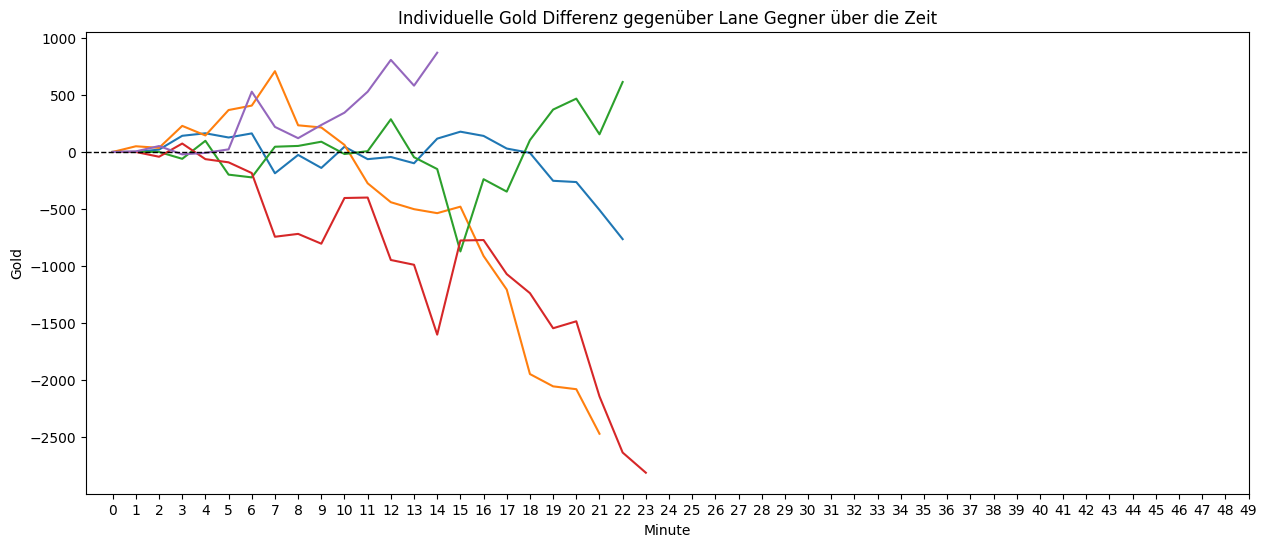

In [514]:
import pandas as pd
import matplotlib.pyplot as plt

# Transponieren Sie das DataFrame, damit jede Zeile eine separate Linie wird
# df_transposed = noway_gold_df.T

# Plot erstellen
plt.figure(figsize=(15, 6))  # Sie können die Größe anpassen

# Iteriere über Zeilen und plote jeden Graphen
for index, row in difference_gold_df.iterrows():
    plt.plot(row, label=index)

# Achsentitel und Legende hinzufügen
plt.xlabel('Minute')
plt.ylabel('Gold')
plt.title('Individuelle Gold Differenz gegenüber Lane Gegner über die Zeit')
minutes = [x for x in range(0, 50, 1)]
plt.xticks(minutes, labels=minutes)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
# Plot anzeigen
plt.show()


In [515]:
noway_gold_df[["min 5", "min 10", "min 15", "min 20"]].mean()
print("Gold von Minute 5 bis 10: ", 3555.243590 - 1637.000000)
print("Gold von Minute 10 bis 15: ", 5815.097222 - 3555.243590)
print("Gold von Minute 15 bis 20: ", 8171.507463 - 5815.097222)

Gold von Minute 5 bis 10:  1918.24359
Gold von Minute 10 bis 15:  2259.8536320000003
Gold von Minute 15 bis 20:  2356.4102409999996


In [516]:
filt = noway_gold_df["win"]
noway_gold_df.loc[filt, ["min 5", "min 10", "min 15", "min 20"]].mean()

min 5     1654.5
min 10    3744.0
min 15    5017.0
min 20    7709.0
dtype: float64

In [517]:
noway_gold_df.loc[~filt, ["min 5", "min 10", "min 15", "min 20"]].mean()

min 5     1551.000000
min 10    3240.666667
min 15    5074.333333
min 20    6497.666667
dtype: float64

In [518]:
time_line = get_time_line(match_list[0])
# participant_index = get_participant_index(time_line, puuid, is_time_line=True)

def get_positions(time_line, participant_index):
    points = {"x": [], "y": []}
    for i in range(24):
        position = time_line["info"]["frames"][i]["participantFrames"][str(participant_index)]["position"]
        points["x"].append(position["x"])
        points["y"].append(position["y"])
    return points

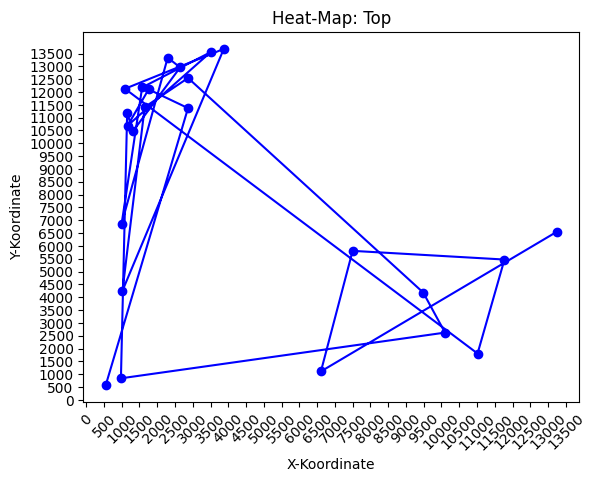

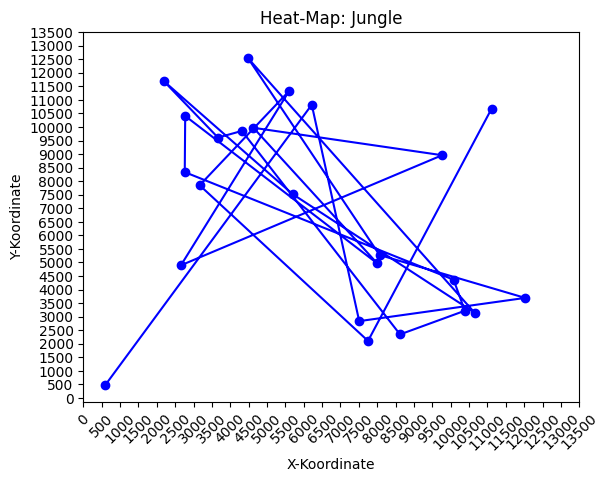

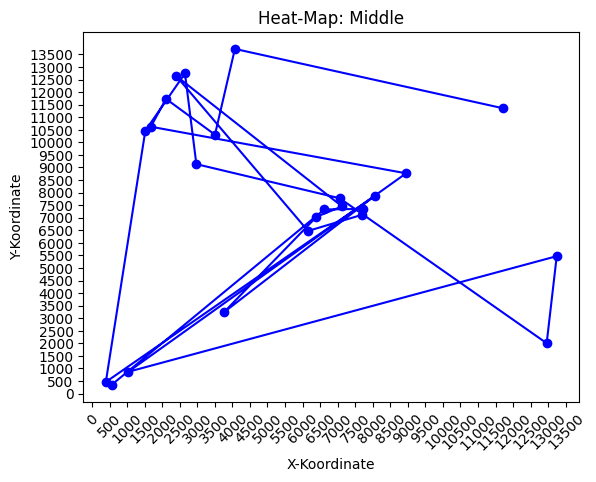

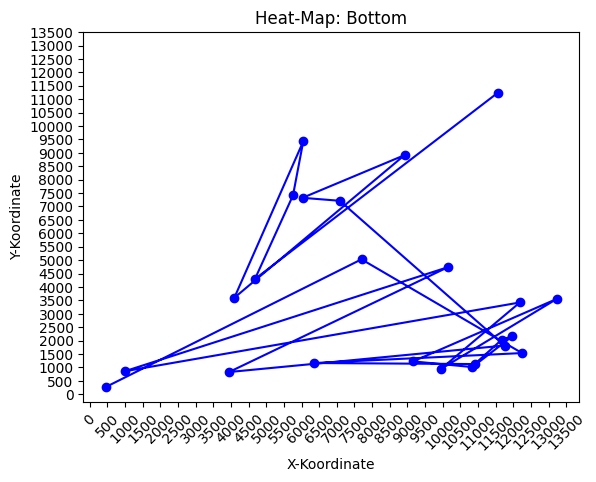

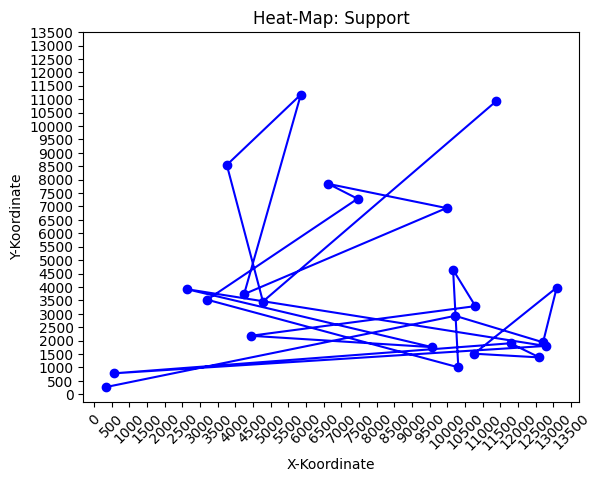

In [519]:
import matplotlib.pyplot as plt

ROLES = ["Top", "Jungle", "Middle", "Bottom", "Support"]


for i in range(1, 6):
    points = get_positions(time_line, i)

    # Plot erstellen
    plt.plot(points['x'], points['y'], marker='o', linestyle='-', color='b')

    # Achsentitel hinzufügen
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.title(f'Heat-Map: {ROLES[i - 1]}')

    plt.xticks([x for x in range(0, 14000, 500)], rotation=45)
    plt.yticks([x for x in range(0, 14000, 500)])

    # Plot anzeigen
    plt.show()
    # input()

In [520]:
match_id = match_list[4]
time_line = get_time_line(match_id)

game_data = get_game_data(match_id)
get_participant_index(time_line, puuid, is_time_line=False)
for i in range(10):
    print(game_data["info"]["participants"][i]["championName"])

Aatrox
Taliyah
Malzahar
Lucian
Rakan
Gragas
LeeSin
Syndra
Kalista
Renata


In [521]:
def print_in_game_time(time_stamp, message):
    minutes = int(time_stamp)
    seconds = int((time_stamp - minutes) * 60)
    print(message, end="\t")
    print(f"ingame time: {minutes}:{seconds}")
    return minutes

In [522]:
participant_index = get_participant_index(time_line, puuid, is_time_line=True)

spawn_x_y = time_line["info"]["frames"][0]["participantFrames"][str(participant_index)]["position"]

points = []
point_dict = {"x": [], "y": []}

for frame in time_line["info"]["frames"]:
    for event in frame["events"]:
        if event["type"] == "CHAMPION_KILL" and event["victimId"] == participant_index:
            print_in_game_time(event["timestamp"] / 60000, "KILLED")
            points.append(point_dict)
            point_dict = {"x": [spawn_x_y["x"]], "y": [spawn_x_y["y"]]}
            break

        if event["type"] == "ITEM_PURCHASED" and event["participantId"] == participant_index:
            minutes = print_in_game_time(event["timestamp"] / 60000, "BASED")
            if minutes < 1:
                continue
            points.append(point_dict)
            point_dict = {"x": [spawn_x_y["x"]], "y": [spawn_x_y["y"]]}
            break

        if event["type"] == "CHAMPION_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "KILL OR ASSIST")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])
        
        if event["type"] == "BUILDING_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "TURRET KILL")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])

        if event["type"] == "CHAMPION_SPECIAL_KILL" and event["killerId"] == participant_index:
            print_in_game_time(event["timestamp"] / 60000, "SPECIAL KILL")
            position = event["position"]
            point_dict["x"].append(position["x"])
            point_dict["y"].append(position["y"])

        if event["type"] == "ELITE_MONSTER_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "ELITE MONSTER KILL")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])

        if event["type"] == "TURRET_PLATE_DESTROYED" and participant_index == event["killerId"]:
            print_in_game_time(event["timestamp"] / 60000, "TURRET_PLATE_DESTROYED")
            position = event["position"]
            point_dict["x"].append(position["x"])
            point_dict["y"].append(position["y"])


    position = frame["participantFrames"][str(participant_index)]["position"]
    point_dict["x"].append(position["x"])
    point_dict["y"].append(position["y"])

BASED	ingame time: 0:4
BASED	ingame time: 0:5
BASED	ingame time: 0:6
BASED	ingame time: 0:6
KILL OR ASSIST	ingame time: 1:7
BASED	ingame time: 4:59
BASED	ingame time: 5:1
KILLED	ingame time: 6:54
BASED	ingame time: 7:2
KILL OR ASSIST	ingame time: 9:7
BASED	ingame time: 9:37
KILL OR ASSIST	ingame time: 11:57
BASED	ingame time: 12:25
KILL OR ASSIST	ingame time: 13:10
KILL OR ASSIST	ingame time: 13:14
KILL OR ASSIST	ingame time: 13:15
KILL OR ASSIST	ingame time: 13:15
KILLED	ingame time: 13:57
BASED	ingame time: 14:1


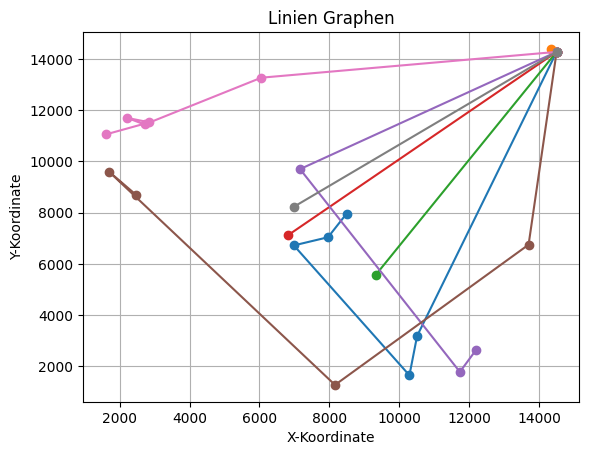

In [523]:
import matplotlib.pyplot as plt

# Plot erstellen
fig, ax = plt.subplots()

# Jede Linie zeichnen
for line_data in points:
    x = line_data['x']
    y = line_data['y']
    ax.plot(x, y, marker='o')  # Hier kannst du das Marker-Symbol anpassen, wenn gewünscht

# Achsentitel setzen
ax.set_xlabel('X-Koordinate')
ax.set_ylabel('Y-Koordinate')

# Titel setzen
ax.set_title('Linien Graphen')

# Legende hinzufügen
# ax.legend([f'Linie {i+1}' for i in range(len(points))])

# Grid anzeigen (optional)
ax.grid(True)

# Den Plot anzeigen
plt.show()


In [532]:
event_set = set()

for match_id in lolwatcher.match.matchlist_by_puuid(region=server, puuid=puuid, count=95, queue=420):

    time_line = lolwatcher.match.timeline_by_match(region=region, match_id=match_id)

    for frame in time_line["info"]["frames"]:
        for event in frame["events"]:
            event_set.add(event["type"])

event_set

{'teamId': 100, 'timestamp': 978414, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 1041516, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 1201259, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 979303, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 100, 'timestamp': 1379394, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 1919484, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 100, 'timestamp': 1363388, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 100, 'timestamp': 1189494, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 1799384, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 200, 'timestamp': 1650361, 'type': 'OBJECTIVE_BOUNTY_FINISH'}
-------------------
{'teamId': 100, 'timestamp': 1622397, 'type': 'OBJECTIVE_BOUNTY_FINISH'}

{'BUILDING_KILL',
 'CHAMPION_KILL',
 'CHAMPION_SPECIAL_KILL',
 'CHAMPION_TRANSFORM',
 'DRAGON_SOUL_GIVEN',
 'ELITE_MONSTER_KILL',
 'GAME_END',
 'ITEM_DESTROYED',
 'ITEM_PURCHASED',
 'ITEM_SOLD',
 'ITEM_UNDO',
 'LEVEL_UP',
 'OBJECTIVE_BOUNTY_FINISH',
 'OBJECTIVE_BOUNTY_PRESTART',
 'PAUSE_END',
 'SKILL_LEVEL_UP',
 'TURRET_PLATE_DESTROYED',
 'WARD_KILL',
 'WARD_PLACED'}